In [6]:
# Import monai and ITK
import monai
import itk
import numpy as np
import matplotlib.pyplot as plt

In [1]:
from monai.apps import DecathlonDataset

# Set the directory where you want to download the dataset


from pathlib import Path
directory = Path("Data")
directory.mkdir(exist_ok=True)
task_name = "Task08_HepaticVessel"
if not directory.joinpath(task_name).exists():
    ds = DecathlonDataset(
        root_dir=str(directory),
        task=task_name,
        section="training",
        download=True,
        cache_rate=0.0,
    )
else:
    ds = DecathlonDataset(root_dir=str(directory), task=task_name, section="training", download=False, cache_rate=0.0)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


In [4]:
# Access an image from the dataset (change index as needed)
image_path = ds.data[0]["image"]
itk_image = itk.imread(str(image_path))

# Compute basic statistics using ITK
statistics_filter = itk.StatisticsImageFilter.New(itk_image)
statistics_filter.Update()

# Extract computed statistics
mean = statistics_filter.GetMean()
variance = statistics_filter.GetVariance()
minimum = statistics_filter.GetMinimum()
maximum = statistics_filter.GetMaximum()

# Print the computed statistics
print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"Minimum: {minimum}")
print(f"Maximum: {maximum}")


Mean: -629.4524821888317
Variance: 243278.19429330732
Minimum: -1024.0
Maximum: 1302.0


Fast marching level-set segmentation


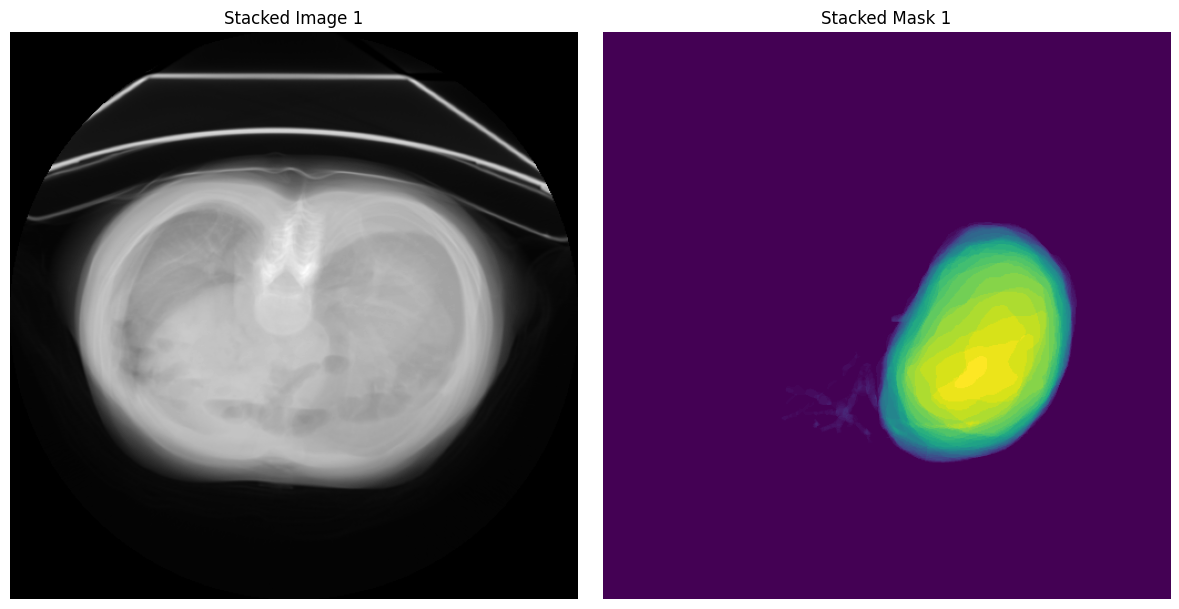

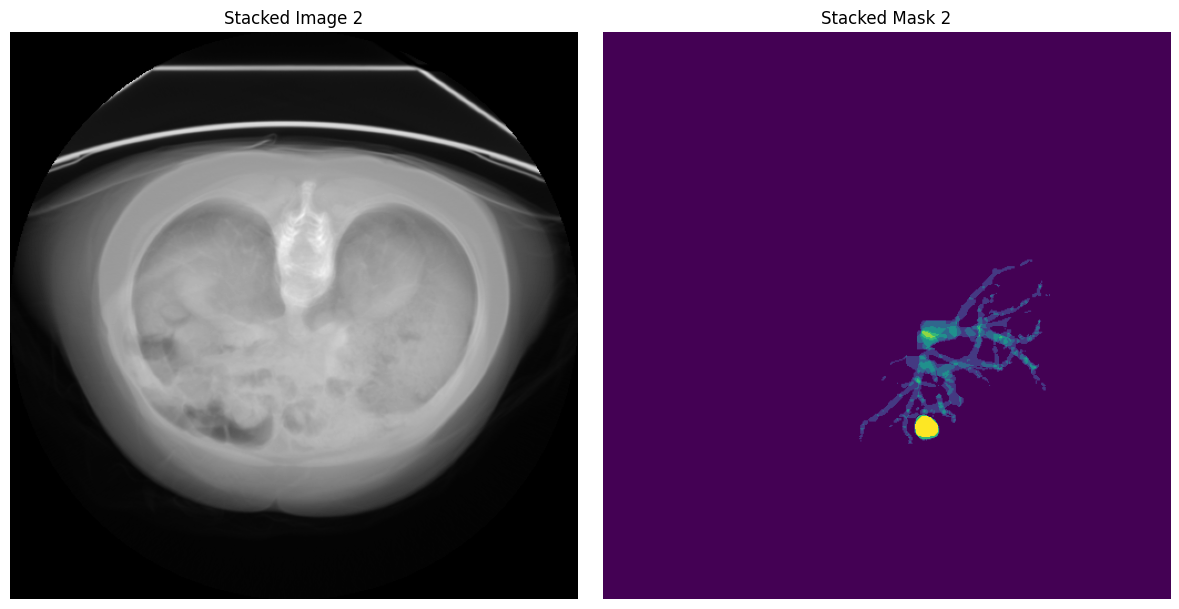

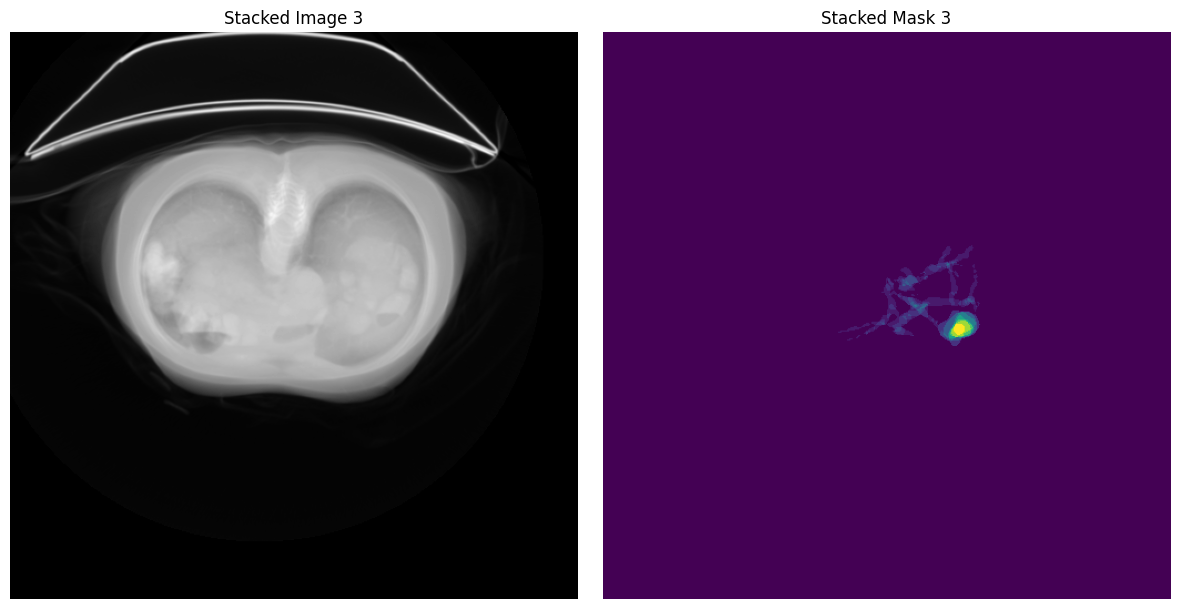

In [10]:
import matplotlib.pyplot as plt

num_images_to_plot = 3
for i in range(num_images_to_plot):
    image_path = ds.data[i]["image"]
    itk_image = itk.imread(str(image_path))
    image_array = itk.GetArrayFromImage(itk_image)

    mask_path = ds.data[i]["label"]
    itk_mask = itk.imread(str(mask_path))
    mask_array = itk.GetArrayFromImage(itk_mask)
    stacked_image = image_array
    stacked_mask = mask_array

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(stacked_image.sum(axis=0), cmap='gray')  # Sum along z-axis for visualization
    axes[0].set_title(f"Stacked Image {i+1}")
    axes[0].axis('off')

    axes[1].imshow(stacked_mask.sum(axis=0), cmap='viridis')  # Sum along z-axis for visualization
    axes[1].set_title(f"Stacked Mask {i+1}")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
